# Aplicar el análisis de clases latentes

## Configurar



In [ ]:
#eliminar archivos previos y limpiar la memoria del entorno
rm(list=ls());gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,650586,34.8,1439855,76.9,1297948,69.4
Vcells,1212098,9.3,8388608,64.0,1924951,14.7


In [1]:

url <- "https://www.dropbox.com/scl/fi/3o58dwzew97q2r69r8vi3/palestine_25.RData?rlkey=6ur8jbxgl12h66k49e2e93325&st=yzcaoo4i&dl=1"
download.file(url, destfile = "palestine_25.RData", mode = "wb")

# Cargar el archivo
load("palestine_25.RData")


options(install.packages.check.source = "yes") # Chequea la fuente de los paquetes


if(!require(pacman)){install.packages("pacman");require(pacman)}

# Definir el vector de paquetes requeridos.
# Los paquetes comentados son opcionales; se mantienen en la estructura para referencia.
required_packages <- c(
  "showtext",    # Para cambiar la fuente de las letras
  "ggplot2",     # Para elaborar gráficos
  "plotly",      # Para elaborar gráficos interactivos
  "magick",      # Para mostrar imágenes
  "knitr",       # Para hacer tablas e interactuar con informes
  "tidyverse",   # Para manipular bases de datos
  "rio",         # Para importar y exportar bases de datos en distintos formatos
  "psych",       # Para explorar variables
  "parallel",    # Para paralelizar los procesos en la CPU
  "doParallel",  # Para paralelizar los procesos en la CPU
  "glca",        # Para llevar a cabo análisis de clases latentes
  "DiagrammeR",  # Para generar gráficos esquemáticos
  "DiagrammeRsvg", # Para exportar gráficos
  "rsvg",        # Para transformar gráficos en formato .svg
  "htmlwidgets", # Para visualizarlos en una presentación
  "janitor",     # Permite limpiar bases de datos, entre otras funciones
  "tableone"
)

# Instalar el paquete 'pak' si no está instalado
if (!requireNamespace("pak", quietly = TRUE)) {
  install.packages("pak")
}

# Instalar (o actualizar) los paquetes requeridos usando pak.
# pak es más rápido y maneja las dependencias de manera eficiente.
pak::pkg_install(required_packages)

# Cargar los paquetes instalados
invisible(lapply(required_packages, library, character.only = TRUE))

#url <- "https://www.dropbox.com/scl/fi/a76o70v6fjyy7pzgsu1vr/paquetes.tar.gz?rlkey=17ms7rx434wyz60y4ty3isovf&st=uw63uatn&dl=1"
##download.file(url, destfile = "paquetes.tar.gz", mode = "wb")

# Paso 2: Descomprimir el archivo
# untar("paquetes.tar.gz")

# Paso 3: Instalar todos los paquetes desde los .tar.gz
#paquetes <- list.files("/content/paquetes_tar", pattern = "\\.tar\\.gz$", full.names = TRUE)
#for (pkg in paquetes) {
## install.packages(pkg, repos = NULL, type = "source")
#}

#Archivos del sistema que también instala
#ℹ Executing `sh -c apt-get -y install pandoc libmagick++-dev gsfonts libfribidi-dev libharfbuzz-dev libglpk-dev libnode-dev librsvg2-dev`


#para comparaciones
if(!require(chisq.posthoc.test)){devtools::install_github("ebbertd/chisq.posthoc.test")}

Loading required package: pacman

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘pacman’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: pacman

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



✔ Updated metadata database: 3.18 MB in 8 files.



ℹ Updating metadata database

✔ Updating metadata database ... done



 

→ Will install 152 packages.

→ Will download 152 CRAN packages (125.55 MB).

+ askpass         1.2.1      [bld][cmp][dl] (6.06 kB)
+ backports       1.5.0      [bld][cmp][dl] (30.69 kB)
+ base64enc       0.1-3      [bld][cmp][dl] (7.83 kB)
+ bit             4.6.0      [bld][cmp][dl] (304.58 kB)
+ bit64           4.6.0-1    [bld][cmp][dl] (142.04 kB)
+ blob            1.2.4      [bld][dl] (10.62 kB)
+ broom           1.0.8      [bld][dl] (651.24 kB)
+ bslib           0.9.0      [bld][dl] (5.4

── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/Rtmpr2YdJz/remotes16544c4504/ebbertd-chisq.posthoc.test-186d2ca/DESCRIPTION’ ... OK
* preparing ‘chisq.posthoc.test’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
Omitted ‘LazyData’ from DESCRIPTION
* building ‘chisq.posthoc.test_0.1.3.tar.gz’

── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/Rtmpr2YdJz/remotes16544c4504/ebbertd-chisq.posthoc.test-186d2ca/DESCRIPTION’ ... OK
* preparing ‘chisq.posthoc.test’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
Omitted ‘LazyData’ from DESCRIPTION
* building ‘chisq.posthoc.test_0.1.3.tar.gz’



Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



## Describimos los datos de interés


In [2]:
variables_interes <- c("QKUW40_1", "QKUW40_2", "QKUW40_3", "QKUW40_4",
                       "QKUW40_5", "QKUW40_90", "QKUW40_97", "QKUW40_98",
                       "QKUW40_99", "Q1002", "Q1005")


# Crear un subconjunto de las variables de interés, actualizado
variables_interes_act <-
c("Apoyo1. Boicot a empresas que apoyan a Israel", "Apoyo2. Seguimiento continuo de noticias relacionadas con la guerra",
"Apoyo3. Participación en actividades públicas de solidaridad",
"Apoyo4. Difusión de mensajes de solidaridad en redes sociales",
"Apoyo5. Donaciones monetarias a los residentes de Gaza", "Apoyo90. Otro – Por favor, especifique:",
"Apoyo97. No he tomado ninguna de estas acciones", "Apoyo98. No sabe",
"Apoyo99. Se niega a responder", "Sexo", "Estatus ocupacional")

# Generar la tabla descriptiva
tabla_descriptiva <- CreateTableOne(vars = variables_interes_act,
      data = arabebarometro_selected%>%
         dplyr::mutate(across(
           starts_with("QKUW40_"), ~dplyr::case_when(
             .==0~"No", .==1~"Sí", T~NA_character_
           )))%>%
        dplyr::mutate(Q1005= dplyr::case_when(
    Q1005 == "1" ~ "Empleado",
    Q1005 == "2" ~ "Auto-empleado",
    Q1005 == "3" ~ "Retirado",
    Q1005 == "4" ~ "Dueñ@ de casa",
    Q1005 == "5" ~ "Estudiante",
    Q1005 == "6" ~ "Desempleado/buscando",
    Q1005 == "99" ~ "No responde",
    TRUE ~ NA_character_
  ))%>%
    dplyr::mutate(Q1002= dplyr::case_when(
      Q1002== "1"~ "Hombre",
      Q1002== "2"~ "Mujer",
      T~ NA_character_)) %>%
  dplyr::rename(
    "Apoyo1. Boicot a empresas que apoyan a Israel" = "QKUW40_1",
    "Apoyo2. Seguimiento continuo de noticias relacionadas con la guerra" = "QKUW40_2",
    "Apoyo3. Participación en actividades públicas de solidaridad" = "QKUW40_3",
    "Apoyo4. Difusión de mensajes de solidaridad en redes sociales" = "QKUW40_4",
    "Apoyo5. Donaciones monetarias a los residentes de Gaza" = "QKUW40_5",
    "Apoyo90. Otro – Por favor, especifique:" = "QKUW40_90",
    "Apoyo97. No he tomado ninguna de estas acciones" = "QKUW40_97",
    "Apoyo98. No sabe" = "QKUW40_98",
    "Apoyo99. Se niega a responder" = "QKUW40_99",
    "Sexo" = "Q1002",
    "Estatus ocupacional" = "Q1005"),
  factorVars = variables_interes_act)

# Mostrar la tabla en consola
tabla_df <- as.data.frame(print(tabla_descriptiva, showAllLevels = TRUE, missing = TRUE))
tabla_df <-cbind.data.frame(var= gsub("\\s+", " ",gsub("\\.", " ", rownames(tabla_df))), tabla_df)
rownames(tabla_df)<-NULL
# tabla_df$var <- sub("\\.\\.", ": ", tabla_df$var)
# tabla_df$var <- sub("\\.\\.\\.\\.", "", tabla_df$var)
# tabla_df$var <- sub("\\.", " ", tabla_df$var)
# tabla_df$var <- sub("\\.", " ", tabla_df$var)
# tabla_df$var <- sub("\\.", " ", tabla_df$var)
# tabla_df$var <- sub("\\.$", "", tabla_df$var)
tabla_df$var <- ifelse(grepl("^X", tabla_df$var), "", tabla_df$var)

                                                                         
                                                                          level               
  n                                                                                           
  Apoyo1. Boicot a empresas que apoyan a Israel (%)                       No                  
                                                                          Sí                  
  Apoyo2. Seguimiento continuo de noticias relacionadas con la guerra (%) No                  
                                                                          Sí                  
  Apoyo3. Participación en actividades públicas de solidaridad (%)        No                  
                                                                          Sí                  
  Apoyo4. Difusión de mensajes de solidaridad en redes sociales (%)       No                  
                                                                       

In [3]:
tabla_df%>%
  knitr::kable("markdown", caption="Descriptivos", col.names=c("Variable", "Categoría", "Total", "Perdidos"))#%>%
  #kableExtra::kable_styling(bootstrap_options = c("striped", "hover"),font_size = 12) %>%
  #kableExtra::scroll_box(width = "100%", height = "575px")



Table: Descriptivos

|Variable                                                           |Categoría            |Total       |Perdidos |
|:------------------------------------------------------------------|:--------------------|:-----------|:--------|
|n                                                                  |                     |1210        |         |
|Apoyo1 Boicot a empresas que apoyan a Israel                       |No                   |200 (16.5)  |0.0      |
|                                                                   |Sí                   |1010 (83.5) |         |
|Apoyo2 Seguimiento continuo de noticias relacionadas con la guerra |No                   |598 (49.4)  |0.0      |
|                                                                   |Sí                   |612 (50.6)  |         |
|Apoyo3 Participación en actividades públicas de solidaridad        |No                   |950 (78.5)  |0.0      |
|                                                        



Table: Descriptivos

|Variable                                                           |Categoría            |Total       |Perdidos |
|:------------------------------------------------------------------|:--------------------|:-----------|:--------|
|n                                                                  |                     |1210        |         |
|Apoyo1 Boicot a empresas que apoyan a Israel                       |No                   |200 (16.5)  |0.0      |
|                                                                   |Sí                   |1010 (83.5) |         |
|Apoyo2 Seguimiento continuo de noticias relacionadas con la guerra |No                   |598 (49.4)  |0.0      |
|                                                                   |Sí                   |612 (50.6)  |         |
|Apoyo3 Participación en actividades públicas de solidaridad        |No                   |950 (78.5)  |0.0      |
|                                                        

Generamos el análisis de clases latentes utilizando distintas soluciones, que van desde las 02 a las 10 clases.


In [4]:
vector_items<- c("QKUW40_1", "QKUW40_2", "QKUW40_3", "QKUW40_4", "QKUW40_5", "QKUW40_90", "QKUW40_97", "QKUW40_98", "QKUW40_99")
colSums(is.na(arabebarometro_selected[,vector_items]))


QKUW40_1  QKUW40_2  QKUW40_3  QKUW40_4  QKUW40_5 QKUW40_90 QKUW40_97 QKUW40_98 
        0         0         0         0         0         0         0         0 
QKUW40_99 
        0

In [5]:
#Definimos el modelo: ítems manifiestos son explicados por una variable latente
f_lca<- item(QKUW40_1, QKUW40_2, QKUW40_3, QKUW40_4, QKUW40_5, QKUW40_90, QKUW40_97, QKUW40_98, QKUW40_99) ~ 1
#Semilla aleatoria para reproducibilidad
seed<-2125
#Opciones de la función
verbose<- F # Seguir los resultados. TRUE= ver proceso de convergencia
init <- 1e2 # puntos iniciales sobre los cuales encontrar una solución global. sugiero 5e2
testiter <- 5e1 # Iteraciones para encontrar convergencia sugiero 5e2
#Otros parámetros son : eps = 1e-6 (tolerancia)

old <- Sys.time()

lca02 <- glca(f_lca, data = arabebarometro_selected[,paste0("QKUW40_", c(1:5, 90, 97, 98, 99))], nclass= 2, seed= seed, verbose= verbose, n.init= init, decreasing=T, maxiter=1e4, testiter = testiter)
lca03 <- glca(f_lca, data = arabebarometro_selected[,paste0("QKUW40_", c(1:5, 90, 97, 98, 99))], nclass= 3, seed= seed, verbose= verbose, n.init= init, decreasing=T, maxiter=1e4, testiter = testiter)
lca04 <- glca(f_lca, data = arabebarometro_selected[,paste0("QKUW40_", c(1:5, 90, 97, 98, 99))], nclass= 4, seed= seed, verbose= verbose, n.init= init, decreasing=T, maxiter=1e4, testiter = testiter)
lca05 <- glca(f_lca, data = arabebarometro_selected[,paste0("QKUW40_", c(1:5, 90, 97, 98, 99))], nclass= 5, seed= seed, verbose= verbose, n.init= init, decreasing=T, maxiter=1e4, testiter = testiter)
lca06 <- glca(f_lca, data = arabebarometro_selected[,paste0("QKUW40_", c(1:5, 90, 97, 98, 99))], nclass= 6, seed= seed, verbose= verbose, n.init= init, decreasing=T, maxiter=1e4, testiter = testiter)
lca07 <- glca(f_lca, data = arabebarometro_selected[,paste0("QKUW40_", c(1:5, 90, 97, 98, 99))], nclass= 7, seed= seed, verbose= verbose, n.init= init, decreasing=T, maxiter=1e4, testiter = testiter)
lca08 <- glca(f_lca, data = arabebarometro_selected[,paste0("QKUW40_", c(1:5, 90, 97, 98, 99))], nclass= 8, seed= seed, verbose= verbose, n.init= init, decreasing=T, maxiter=1e4, testiter = testiter)
lca09 <- glca(f_lca, data = arabebarometro_selected[,paste0("QKUW40_", c(1:5, 90, 97, 98, 99))], nclass= 9, seed= seed, verbose= verbose, n.init= init, decreasing=T, maxiter=1e4, testiter = testiter)
lca10 <- glca(f_lca, data = arabebarometro_selected[,paste0("QKUW40_", c(1:5, 90, 97, 98, 99))], nclass= 10, seed= seed, verbose= verbose, n.init= init, decreasing=T, maxiter=1e4, testiter = testiter)

new_med<-(Sys.time())
duracion <- as.numeric(difftime(new_med, old, units = "mins"))
paste0("El modelo tomó ",round(duracion,2),"segundos hasta que todos los análisis fueron computados")

[1] "El modelo tomó 2.88segundos hasta que todos los análisis fueron computados"

Obtenemos índices de ajuste y comparamos las soluciones. Para facilidad, definimos sólo 10 iteraciones, pero debiesen utilizarse al menos 250 como referencia para ver la estabilidad de los índices de ajuste.

Error con 9 modelos, se ejecuta la versión con 5 modelos (lca02 a lca06)

Saving 7 x 7 in image


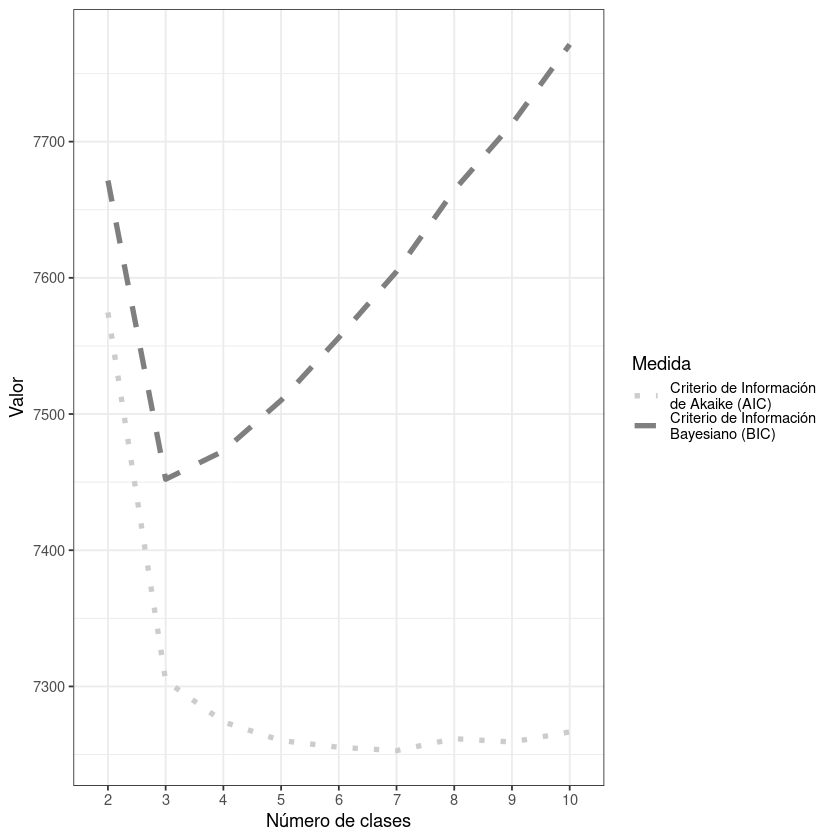

In [ ]:

#para obtener otros índices de ajuste
gof<-
gofglca(lca02, lca03, lca04, lca05, lca06, lca07, lca08, lca09, lca10, test = "chisq")

#número total de clases latentes postuladas
max_classes<- nrow(gof$gtable)+1

#para obtener índice BLRT= Evaluar si el modelo k presenta mejor ajuste que el k-1

#número de iteraciones para bootstrap, se recomienda 5e2 o 250 mínimo
#demora 14 minutos en Google Colab, RAM ampliada // ~10–20 minutos con Google colab normal

if (interactive()) {
  message("Estamos en una sesión interactiva.")
  nboot= 10 # cómo estamos haciendo el ejercicio, ejecuta menos iteraciones
} else {
  nboot= 250 # si no está interactuando, ejecuta más iteraciones
  }

bootlrt <- tryCatch(
  gofglca(lca02, lca03, lca04, lca05, lca06, lca07, lca08, lca09, lca10, test = "boot", nboot = nboot, seed = 2125),
  error = function(e) {
    message("Error con 9 modelos, se ejecuta la versión con 5 modelos (lca02 a lca06)")
    gofglca(lca02, lca03, lca04, lca05, lca06, test = "boot", nboot = nboot, seed = 2125)
  }
)
manualcolors <- rev(c('gray20', 'gray50', 'gray80')) # Tres colores en escala de grises
manual_linetypes <- rev(c('solid', 'dashed', 'dotted')) # Tres estilos de línea
levels <- c("logLik", "Gsq", "AIC", "CAIC", "BIC", "entropy", "Res.Df")
labels <- c('Log-Verosimilitud', 'Chi2', 'Criterio de Información\nde Akaike (AIC)',
            'AIC Corregido', 'Criterio de Información\nBayesiano (BIC)', 'Entropía',
            'Grados de libertad residuales')

fig_lca_fit <- cbind.data.frame(rn = 2:max_classes, gof$gtable) %>%
  data.frame() %>%
  dplyr::mutate_if(is.character, as.numeric) %>%  # Convertir columnas de carácter a numérico
  #formatear la base de manera larga (es decir), cada fila es la combinación única de una probabilidad, pregunta y clase
  tidyr::pivot_longer(cols = -rn, names_to = "indices", values_to = "value", values_drop_na = F) %>%
  #dejar en formato factor los índices, para reconocerlos  e identificarlos
  dplyr::mutate(indices = factor(indices, levels = levels, labels = labels)) %>%
  # Filtrar solo AIC y BIC
  dplyr::filter(grepl("(AIC|BIC)", indices, ignore.case = TRUE)) %>%
  dplyr::mutate(ModelIndex = factor(rn, levels = 2:max_classes)) %>%
  ggplot(aes(x = ModelIndex, y = value, group = indices,
             color = indices, linetype = indices)) +
  geom_line(linewidth = 1.5) +
  # Colores y estilos de línea personalizados
  scale_color_manual(values = manualcolors) +
  scale_linetype_manual(values = manual_linetypes) +
  labs(x = "Número de clases", y = "Valor", color = "Medida", linetype = "Medida") +
  theme_bw()

fig_lca_fit

#Para exportar gráfico
ggsave("_fig2_comparison_glca.png",fig_lca_fit, dpi=600)


Vemos un resumen de la salida del modelo con mejores índices de ajuste BIC.


In [ ]:
#combinamos los índices de ajuste con el índice BLRT
#algunas veces podemos tener problemas de convergencia por tanto no llegar a un cómputo adecuado
#es por eso que utilizamos esta sintaxis para sortear ese problema
merge(2:max_classes, bootlrt$gtable[,"Boot p-value"], by="row.names", all=TRUE)%>%
  {
    colnames(.)<- c("row number", "rn", "blrt")
    .
  }%>%
  select(-`row number`)%>%
  cbind.data.frame(gof$gtable)%>%
    dplyr::mutate(blrt= ifelse(as.numeric(blrt)<.001, "<0.001",sprintf("%1.3f",blrt))) %>%
  dplyr::select(rn, everything()) %>%
  dplyr::rename("N de clases"="rn")%>%
    #aproximamos a dos decimales
  dplyr::mutate(across(c("loglik","AIC", "BIC", "entropy", "Gsq"),~sprintf("%1.2f",.)))%>%
  knitr::kable(format="markdown", caption="Índices de ajuste modelos") #%>%
 # kableExtra::kable_styling(bootstrap_options = c("striped", "hover"),font_size = 12) %>%
 # kableExtra::scroll_box(width = "100%", height = "375px")

mejor_modelo<-
as.numeric(cbind.data.frame(rn=2:max_classes,gof$gtable) %>% dplyr::summarise(which.min(BIC)+1))



Table: Índices de ajuste modelos

| N de clases|blrt   |loglik   |AIC     |BIC     |entropy |  df|Gsq    |
|-----------:|:------|:--------|:-------|:-------|:-------|---:|:------|
|           2|<0.001 |-3768.29 |7574.58 |7671.45 |0.51    | 492|521.21 |
|           3|<0.001 |-3623.14 |7304.28 |7452.13 |0.83    | 482|230.91 |
|           4|<0.001 |-3598.00 |7274.00 |7472.83 |0.86    | 472|180.63 |
|           5|<0.001 |-3581.13 |7260.25 |7510.07 |0.88    | 462|146.88 |
|           6|<0.001 |-3568.67 |7255.34 |7556.14 |0.83    | 452|121.97 |
|           7|NA     |-3557.42 |7252.84 |7604.63 |0.86    | 442|99.47  |
|           8|NA     |-3551.82 |7261.65 |7664.42 |0.85    | 432|88.28  |
|           9|NA     |-3540.60 |7259.21 |7712.96 |0.89    | 422|65.84  |
|          10|NA     |-3534.30 |7266.60 |7771.34 |0.87    | 412|53.23  |

Si vemos índices BLRT con valores NA es porque tuvieron problemas de convergencia.


In [ ]:
summary(
  eval(parse(text = paste0("lca",sprintf("%02.0f",mejor_modelo))))
        ) #


Call:
glca(formula = f_lca, data = arabebarometro_selected[, paste0("QKUW40_", 
    c(1:5, 90, 97, 98, 99))], nclass = 3, n.init = init, decreasing = T, 
    testiter = testiter, maxiter = 10000, seed = seed, verbose = verbose)

Manifest items : QKUW40_1 QKUW40_2 QKUW40_3 QKUW40_4 QKUW40_5 QKUW40_90 QKUW40_97 QKUW40_98 QKUW40_99 

Categories for manifest items :
          Y = 1 Y = 2
QKUW40_1      0     1
QKUW40_2      0     1
QKUW40_3      0     1
QKUW40_4      0     1
QKUW40_5      0     1
QKUW40_90     0     1
QKUW40_97     0     1
QKUW40_98     0     1
QKUW40_99     0     1

Model : Latent class analysis 

Number of latent classes : 3 
Number of observations : 1210 
Number of parameters : 29 

log-likelihood : -3623.139 
     G-squared : 230.9075 
           AIC : 7304.277 
           BIC : 7452.13 

Marginal prevalences for latent classes :
Class 1 Class 2 Class 3 
0.05343 0.74220 0.20437 

Item-response probabilities (Y = 1) :
        QKUW40_1 QKUW40_2 QKUW40_3 QKUW40_4 QKUW40_5

Generamos el modelo con el que vamos a trabajar

In [ ]:
glca_mejor_ajuste<-eval(parse(text = paste0("lca",sprintf("%02.0f",mejor_modelo))))


# Analisis


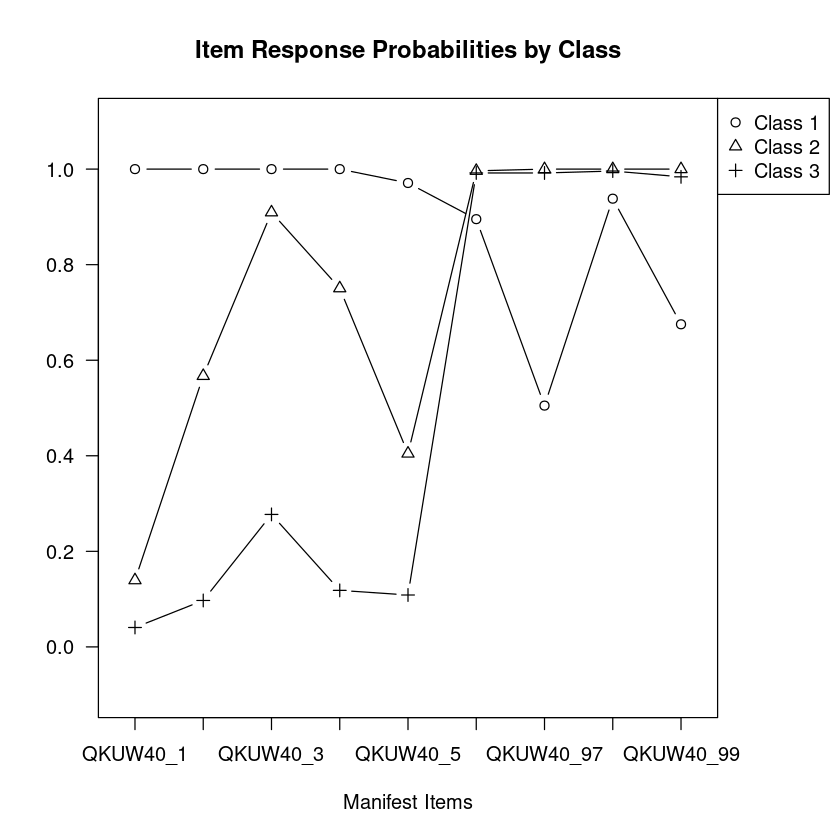

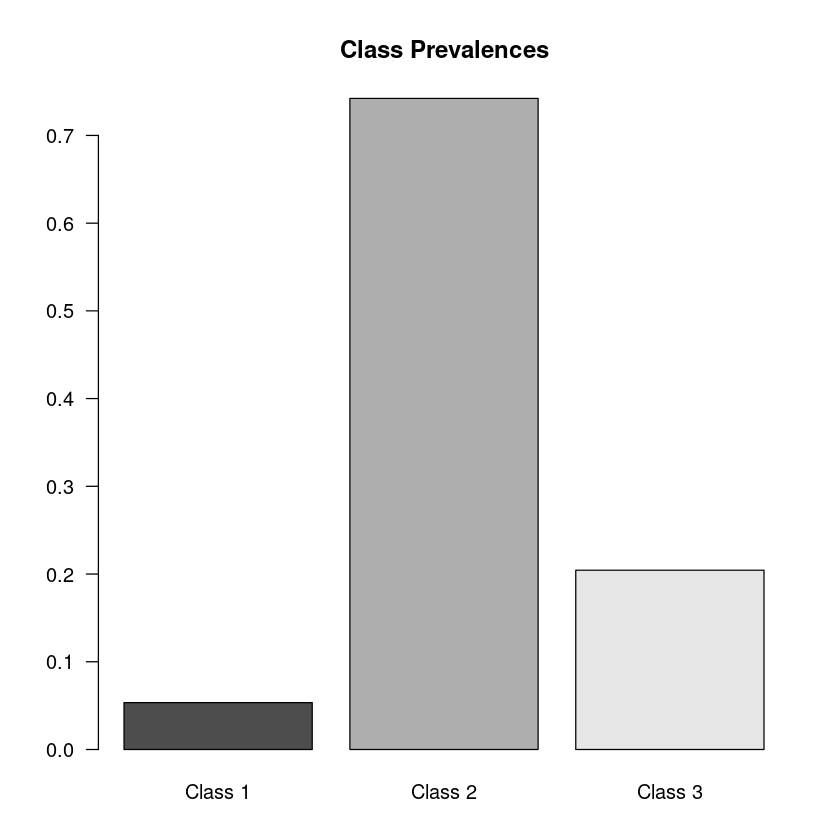

In [ ]:
plot(
     glca_mejor_ajuste
     , ask=F)

Vemos la entropía usando `glca_mejor_ajuste$gof$entropy` `r round(glca_mejor_ajuste$gof$entropy,2)`. Bastante buena.

Ahora veremos los perfiles de las probabilidades de respuesta a los ítems condicionales a la pertenencia a una determinada clase.

In [ ]:
# Configuración inicial y preparación de datos
# Extracción de parámetros rho del modelo GLCA
rho_glca <- do.call("bind_rows", glca_mejor_ajuste$param$rho$ALL) %>%
  t() %>%
  round(2) %>%
  data.table::data.table(keep.rownames = TRUE) %>%
  magrittr::set_colnames(c("variables", paste0("Class", 1:glca_mejor_ajuste$model$C))) %>%
  tidyr::separate(variables, into = c("var", "prob"), sep = ".Y =")

# Transformación de datos del modelo
lcmodel_glca <- rho_glca %>%
  tidyr::pivot_longer(
    cols = 3:5,
    names_to = "class",
    values_to = "value"
  )

# Unión de etiquetas con probabilidades del modelo
lcmodel_glca <- lcmodel_glca %>%
  dplyr::mutate(pr = as.numeric(gsub("[^0-9.]+", "", prob))-1) %>%
  dplyr::mutate(etiqueta= dplyr::case_when(
    grepl("_1$", var) ~ "01.Boicot\nempresas",
    grepl("_2$", var) ~ "02.Seguir\nnoticias",
    grepl("_3$", var) ~ "03.Actividades\nsolidaridad",
    grepl("_4$", var) ~ "04.Difusión\nsolidaridad",
    grepl("_5$", var) ~ "05.Donaciones\nmonetarias",
    grepl("_90$", var) ~ "90.Otro\n(Especificar)",
    grepl("_97$", var) ~ "97.No he tomado\nninguna acción",
    grepl("_98$", var) ~ "98.No sabe",
    grepl("_99$", var) ~ "99.Se niega\nresponder",
    TRUE ~ NA_character_  # Para manejar valores no coincidentes
  ))

# Generación de etiquetas para gráficos
lcmodel_glca$text_label <- paste0(
  "Etiqueta:", lcmodel_glca$etiqueta,
  "<br>Categoría:", lcmodel_glca$pr,
  "<br>%: ", scales::percent(lcmodel_glca$value)
)
#Ordenamos las opciones por orden de aparición
lcmodel_glca$var <- factor(lcmodel_glca$var, levels = paste0("QKUW40_", c(1:5, 90, 97, 98, 99)))

# Cálculo de porcentajes de clase, >.5 PROBABILIDAD DE PERTENENCIA
glca_pop_perc_05 <- glca_mejor_ajuste$posterior$ALL %>%
  dplyr::mutate_all(~ ifelse(. > .5, 1, 0)) %>%
  dplyr::mutate(final_05 = dplyr::case_when(
    `Class 1` == 1 ~ 1, `Class 2` == 1 ~ 2, `Class 3` == 1 ~ 3
  )) %>%
  janitor::tabyl(final_05) %>%
  dplyr::mutate(
    percent = scales::percent(percent, accuracy = .1),
    class = paste0("Clase", final_05),
    print = paste0(class, "\n(n=", n, ";", percent, ")")
  )
# Cálculo de porcentajes de clase, >.7 PROBABILIDAD DE PERTENENCIA
glca_pop_perc_07 <- glca_mejor_ajuste$posterior$ALL %>%
  dplyr::mutate_all(~ ifelse(. > .7, 1, 0)) %>%
  dplyr::mutate(final_07 = dplyr::case_when(
    `Class 1` == 1 ~ 1, `Class 2` == 1 ~ 2, `Class 3` == 1 ~ 3
  )) %>%
  janitor::tabyl(final_07) %>%
  dplyr::mutate(
    percent = scales::percent(percent, accuracy = .1),
    class = paste0("Clase", final_07),
    print_07 = paste0(class, "[>.7 prob]","\n(n=", n, ";", percent, ")")
  ) %>%
  #sacamos sujetos no clasificados
  dplyr::filter(!is.na(final_07)) %>%
  #seleccionamos columnas de interés para unir y no generar redundancia
  dplyr::select(final_07, class, print_07)

# Unión con datos transformados
lcmodel_glca <- lcmodel_glca %>%
  dplyr::mutate(class=gsub("Class","Clase",class)) %>%
  left_join(glca_pop_perc_05, by = c("class")) %>%
  left_join(glca_pop_perc_07, by = c("class")) %>%
  dplyr::select(-class) %>%
  dplyr::rename("class" = "print")

# Gráfico principal
zp <- ggplot(dplyr::mutate(lcmodel_glca, class=gsub("\n","",class)), aes(x = var, y = value, fill = factor(pr), label = text_label)) +
  geom_bar(stat = "identity", position = "stack") +
  facet_grid(class ~ .) +
  scale_fill_brewer(type = "seq", palette = "Greys", na.value = "white") +
  theme_bw() +
  labs(
    y = "Porcentaje de probabilidad de respuesta",
    x = "",
    fill = "Categorías de\nRespuesta"
  ) +
  theme(
    axis.text.y = element_blank(),
    axis.ticks.y = element_blank(),
    panel.grid.major.y = element_blank(),
    axis.text.x = element_text(angle = 30, hjust = 1)
  ) +
  guides(fill = guide_legend(reverse = TRUE))

# Exportación del gráfico y datos
# ggplotly(zp, tooltip = c("text_label")) %>%
#   layout(xaxis = list(showticklabels = TRUE), height = 600, width = 1000)
ggplotly(zp, tooltip = c("text_label")) %>%
  layout(
    legend = list(
      orientation = "h", # Leyenda horizontal
      x = 0.5,           # Centra horizontalmente
      y = -0.2           # Mueve la leyenda debajo del gráfico
    ),
    xaxis = list(showticklabels = TRUE),
    height = 700, # Ajusta la altura
    width = 700, # Ajusta el ancho
    margin = list(l = 100, r = 50, t = 50, b = 150) # Márgenes para etiquetas y títulos
  )
zp
#EXPORTAMOS EL GRÁFICO NO-INTERACTIVO
ggsave("_fig4_LCA_patrones_respuesta.png", zp, dpi = 600)

Output hidden; open in https://colab.research.google.com to view.

Generamos una tabla para ver las probabilidades de respuesta condicional a la pertenencia a una clase latente.

In [ ]:
#Exportar las tablas obtenidas
lcmodel_glca %>%
  #excluimos columnas de procesos intermedios que pueden confundirnos
  dplyr::select(-any_of(c("text_label", "prob", "n", "percent", "final_05", "final_07"))) %>%
  #sacamos información redundante
  #utilizamos doble escape (\\) para sacar símbolos que pueden ser interpretados literalmente
  dplyr::mutate(print_07 = gsub("\\[>\\.7 prob\\]\\n", " ", print_07))%>%
  dplyr::mutate((across(c("etiqueta", "class"),~gsub("\n", " ",.))))%>%
  #renombramos columnas para mayor claridad
  dplyr::rename("Prob. de pertencer a clase [P>.5]"="class", "Prob. de pertencer a clase [P>.7]"="print_07") %>%
  {
  rio::export(.,"_output/variables_probabilidades_respuesta.xlsx")
  rio::export(.,"_output/variables_probabilidades_respuesta.csv")
  knitr::kable(.,"markdown", caption= "Probabilidades de respuesta de cada clase y clasificaciones por según distintos criterios de clasificación por probabilidad posterior de pertenencia", escape=F)
  }



Table: Probabilidades de respuesta de cada clase y clasificaciones por según distintos criterios de clasificación por probabilidad posterior de pertenencia

|var       | value| pr|etiqueta                       |Prob. de pertencer a clase [P>.5] |Prob. de pertencer a clase [P>.7] |
|:---------|-----:|--:|:------------------------------|:---------------------------------|:---------------------------------|
|QKUW40_1  |  1.00|  0|01.Boicot empresas             |Clase1 (n=64;5.3%)                |Clase1 (n=64;5.3%)                |
|QKUW40_1  |  0.14|  0|01.Boicot empresas             |Clase2 (n=946;78.2%)              |Clase2 (n=856;70.7%)              |
|QKUW40_1  |  0.04|  0|01.Boicot empresas             |Clase3 (n=200;16.5%)              |Clase3 (n=152;12.6%)              |
|QKUW40_1  |  0.00|  1|01.Boicot empresas             |Clase1 (n=64;5.3%)                |Clase1 (n=64;5.3%)                |
|QKUW40_1  |  0.86|  1|01.Boicot empresas             |Clase2 (n=946;78.2%)          


<br>

A partir del gráfico anterior y la tabla, podemos interpretar las clases:

**Clase 1**= Describe a personas que no han tomado ninguna acción concreta, no saben o no responden.

**Clase 2**= Describe a personas que han actuado de forma individual e internalizante.

**Clase 3**= Describe a personas que han actuado de muchas formas, incluidas acciones colectivas, mobilizaciones y difusión.

De ahí uno podría hacer interpretaciones en contraste con teorías de movimientos sociales, *advocacy groups*, etc. Por ejemplo, grupos que reflejan actitudes de desmovilización o desconexión, grupos de acciones individuales, simbólicas o de bajo costo ("participación selectiva" / *free-riding*), y un grupo cuya movilización tiende a ser colectiva, incorporando recursos y redes con mayor nivel de compromiso y participación activa.

<br>

In [ ]:

posterior_glca_05<-
glca_mejor_ajuste$posterior$ALL %>%
    dplyr::mutate_all(~ifelse(.>.5,1,0)) %>%
  dplyr::mutate(final_05=dplyr::case_when(`Class 1`==1~1,`Class 2`==1~2, `Class 3`==1~3))

posterior_glca_07<-
glca_mejor_ajuste$posterior$ALL %>%
    dplyr::mutate_all(~ifelse(.>.7,1,0)) %>%
  dplyr::mutate(final_07=dplyr::case_when(`Class 1`==1~1,`Class 2`==1~2, `Class 3`==1~3))


glca_mejor_ajuste$posterior$ALL %>%
  dplyr::mutate_all(~ ifelse(. > .5, 1, 0)) %>%
  dplyr::mutate(final_05 = dplyr::case_when(
    `Class 1` == 1 ~ 1, `Class 2` == 1 ~ 2, `Class 3` == 1 ~ 3
  )) %>%
  dplyr::mutate(final_07= posterior_glca_07$final_07) %>%
  janitor::tabyl(final_05, final_07) %>%
  dplyr::rename("No clasificado" = "NA_") %>%
  knitr::kable(
    col.names = c("Clases", "Clase 1", "Clase 2", "Clase 3", "No clasificado"),
    caption = "Clasificación por valores superiores a 0,7 en probabilidad vs. 0,5"
  )

posterior_glca_07 %>%
    rowwise() %>%
  dplyr::mutate(count_ones = sum(c_across(starts_with("Class")) == 1)) %>%
  ungroup() %>%
  janitor::tabyl(final_07,count_ones) %>%
  knitr::kable(col.names= c("Clasificación por valores superiores a 0,7 en probabilidad", "0", "1"), caption="Pruebas por probabilidades de clasificación posterior")



Table: Clasificación por valores superiores a 0,7 en probabilidad vs. 0,5

| Clases| Clase 1| Clase 2| Clase 3| No clasificado|
|------:|-------:|-------:|-------:|--------------:|
|      1|      64|       0|       0|              0|
|      2|       0|     856|       0|             90|
|      3|       0|       0|     152|             48|



Table: Pruebas por probabilidades de clasificación posterior

| Clasificación por valores superiores a 0,7 en probabilidad|   0|   1|
|----------------------------------------------------------:|---:|---:|
|                                                          1|   0|  64|
|                                                          2|   0| 856|
|                                                          3|   0| 152|
|                                                         NA| 138|   0|

Vemos que hay algunas observaciones que si clasificáramos por un criterio más estricto de pertenencia (al menos 49% de la variabilidad es explicada por la clase) no alcanzan a pertenecer a una determinada clase.

<br>

# Caracterización/ Comparación con otras variables

## Clasificar-analizar

In [ ]:
invisible("Ocupación (Q1005)")
cbind.data.frame(ocupacion=arabebarometro_selected$Q1005, clasif_05= posterior_glca_05$final_05) %>%
    dplyr::mutate(ocupacion= dplyr::case_when(ocupacion%in%c("1","2")~"activa", ocupacion=="5"~"estudiante", T~"inactiva"))%>%
    dplyr::group_by(ocupacion, clasif_05)%>%
    dplyr::count() %>%
    dplyr::mutate(clasif_05= dplyr::case_when(clasif_05=="1"~"Clase1",clasif_05=="2"~"Clase2", clasif_05=="3"~"Clase3", T~NA_character_))%>%
    tidyr::pivot_wider(names_from = clasif_05, values_from= n)%>%
  dplyr::mutate(total= Clase1+Clase2+Clase3)%>%
  dplyr::mutate(Clase1= glue::glue("{Clase1}({scales::percent(Clase1/total)})"))%>%
  dplyr::mutate(Clase2= glue::glue("{Clase2}({scales::percent(Clase2/total)})"))%>%
  dplyr::mutate(Clase3= glue::glue("{Clase3}({scales::percent(Clase3/total)})"))

cbind.data.frame(ocupacion= arabebarometro_selected$Q1005, clasif_05= posterior_glca_05$final_05) %>%
    dplyr::mutate(ocupacion= dplyr::case_when(ocupacion%in%c("1","2")~"activa", ocupacion=="5"~"estudiante", T~"inactiva"))%>%
    janitor::tabyl(ocupacion, clasif_05)%>%
    janitor::chisq.test()

#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_
#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_

invisible("Sexo (Q1002)")
cbind.data.frame(sexo=arabebarometro_selected$Q1002, clasif_05= posterior_glca_05$final_05) %>%
  dplyr::group_by(sexo, clasif_05)%>%
  dplyr::count() %>%
  dplyr::mutate(sexo= ifelse(sexo=="1","hombre", "mujer"))%>%
    dplyr::mutate(clasif_05= dplyr::case_when(clasif_05=="1"~"Clase1",clasif_05=="2"~"Clase2", clasif_05=="3"~"Clase3", T~NA_character_))%>%
  tidyr::pivot_wider(names_from = clasif_05, values_from= n)%>%
  dplyr::mutate(total= Clase1+Clase2+Clase3)%>%
  dplyr::mutate(Clase1= glue::glue("{Clase1}({scales::percent(Clase1/total)})"))%>%
  dplyr::mutate(Clase2= glue::glue("{Clase2}({scales::percent(Clase2/total)})"))%>%
  dplyr::mutate(Clase3= glue::glue("{Clase3}({scales::percent(Clase3/total)})"))

chisq.test(arabebarometro_selected$Q1002, posterior_glca_05$final_05)

chisq.posthoc.test(table(arabebarometro_selected$Q1002,posterior_glca_05$final_05))

cbind.data.frame(sexo=arabebarometro_selected$Q1002, clasif_07= posterior_glca_07$final_07) %>%
  dplyr::group_by(sexo, clasif_07) %>%
  dplyr::count() %>%
  dplyr::mutate(sexo= ifelse(sexo=="1","hombre", "mujer"))%>%
  dplyr::mutate(clasif_07= dplyr::case_when(clasif_07=="1"~"Clase1",clasif_07=="2"~"Clase2", clasif_07=="3"~"Clase3", T~NA_character_))%>%
  tidyr::pivot_wider(names_from = clasif_07, values_from= n)%>%
  dplyr::mutate(total= Clase1+Clase2+Clase3)%>%
  dplyr::mutate(Clase1= glue::glue("{Clase1}({scales::percent(Clase1/total)})"))%>%
  dplyr::mutate(Clase2= glue::glue("{Clase2}({scales::percent(Clase2/total)})"))%>%
  dplyr::mutate(Clase3= glue::glue("{Clase3}({scales::percent(Clase3/total)})"))

#excluimos los casos perdidos
chisq.test(table(arabebarometro_selected$Q1002[!is.na(posterior_glca_07$final_07)],posterior_glca_07$final_07[!is.na(posterior_glca_07$final_07)]))

#obtenemos los resultados
chisq.posthoc.test(table(arabebarometro_selected$Q1002[!is.na(posterior_glca_07$final_07)],posterior_glca_07$final_07[!is.na(posterior_glca_07$final_07)]))

ocupacion,Clase1,Clase2,Clase3,total
<chr>,<glue>,<glue>,<glue>,<int>
activa,30(4%),543(79%),118(17%),691
estudiante,9(6%),104(68%),40(26%),153
inactiva,25(7%),299(82%),42(11%),366



	Pearson's Chi-squared test

data:  .
X-squared = 19.887, df = 4, p-value = 0.0005256


sexo,Clase1,Clase2,Clase3,total
<chr>,<glue>,<glue>,<glue>,<int>
hombre,27(4%),488(79%),106(17%),621
mujer,37(6%),458(78%),94(16%),589



	Pearson's Chi-squared test

data:  arabebarometro_selected$Q1002 and posterior_glca_05$final_05
X-squared = 2.3893, df = 2, p-value = 0.3028


Dimension,Value,1,2,3
<chr>,<chr>,<dbl>,<dbl>,<dbl>
1,Residuals,-1.502353,0.3468845,0.5195646
1,p values,0.798000,1.0000000,1.0000000
2,Residuals,1.502353,-0.3468845,-0.5195646
2,p values,0.798000,1.0000000,1.0000000


sexo,Clase1,Clase2,Clase3,NA,total
<chr>,<glue>,<glue>,<glue>,<int>,<int>
hombre,27(5%),438(80%),83(15%),73,548
mujer,37(7%),418(80%),69(13%),65,524



	Pearson's Chi-squared test

data:  table(arabebarometro_selected$Q1002[!is.na(posterior_glca_07$final_07)],     posterior_glca_07$final_07[!is.na(posterior_glca_07$final_07)])
X-squared = 2.7833, df = 2, p-value = 0.2487


Dimension,Value,1,2,3
<chr>,<chr>,<dbl>,<dbl>,<dbl>
1,Residuals,-1.474144,0.0636584,0.9280558
1,p values,0.842700,1.0000000,1.0000000
2,Residuals,1.474144,-0.0636584,-0.9280558
2,p values,0.842700,1.0000000,1.0000000


## Modelo con covariable


In [ ]:
f_lca_adj<- item(QKUW40_1, QKUW40_2, QKUW40_3, QKUW40_4, QKUW40_5, QKUW40_90, QKUW40_97, QKUW40_98, QKUW40_99) ~ Q1002 + Q1005
lca03_adj <- glca(f_lca_adj, data = arabebarometro_selected[,c(paste0("QKUW40_", c(1:5, 90, 97, 98, 99)),"Q1002", "Q1005")]%>% dplyr::mutate(Q1005= dplyr::case_when(Q1005%in%c("1","2")~"activa", Q1005=="5"~"estudiante", T~"inactiva")),
    nclass= 3,
    seed= seed,
    verbose= verbose,
    n.init= init,
    decreasing=T,
    maxiter=1e4,
    testiter = testiter)

Vemos los coeficientes de regresión

In [ ]:

summary(lca03_adj)
knitr::kable(lca03_adj$coefficient, "markdown")
#str(lca03_adj$c)


Call:
glca(formula = f_lca_adj, data = arabebarometro_selected[, c(paste0("QKUW40_", 
    c(1:5, 90, 97, 98, 99)), "Q1002", "Q1005")] %>% dplyr::mutate(Q1005 = dplyr::case_when(Q1005 %in% 
    c("1", "2") ~ "activa", Q1005 == "5" ~ "estudiante", T ~ 
    "inactiva")), nclass = 3, n.init = init, decreasing = T, 
    testiter = testiter, maxiter = 10000, seed = seed, verbose = verbose)

Manifest items : QKUW40_1 QKUW40_2 QKUW40_3 QKUW40_4 QKUW40_5 QKUW40_90 QKUW40_97 QKUW40_98 QKUW40_99 
Covariates (Level 1) : Q1002 Q1005 

Categories for manifest items :
          Y = 1 Y = 2
QKUW40_1      0     1
QKUW40_2      0     1
QKUW40_3      0     1
QKUW40_4      0     1
QKUW40_5      0     1
QKUW40_90     0     1
QKUW40_97     0     1
QKUW40_98     0     1
QKUW40_99     0     1

Model : Latent class analysis 

Number of latent classes : 3 
Number of observations : 1210 
Number of parameters : 35 

log-likelihood : -3609.049 
     G-squared : 501.9874 
           AIC : 7288.099 
           BIC 


- Podría decirse que hombres empleados (intercepto) tienen mayores chances de pertenecer a la clase 1 vs. la 3  (OR= 11.3), y 2 vs. 3 (OR= 2.5)
- Encontrarse inactivo (retirado, dueñ@ de casa o desempleado y buscando trabajo vs. empleados) se asocia a menores chances de pertenecer a la clase 1 vs. la 3.
- No hay evidencia de una asociación entre pertenecer a una clase y el sexo.

Tener en cuenta la escasez de observaciones para algunas categorías de respuesta.

In [ ]:
lca03_adj$param$beta$ALL %>% data.frame()%>% mutate_if(is.numeric, ~sprintf("%1.2f", .))%>% knitr::kable("markdown", col.names= c("Terms", "Class 1 vs. 3", "Class 2 vs. 3"))



|Terms           |Class 1 vs. 3 |Class 2 vs. 3 |
|:---------------|:-------------|:-------------|
|(Intercept)     |-2.43         |0.90          |
|Q1002           |0.55          |0.22          |
|Q1005estudiante |-0.17         |-0.66         |
|Q1005inactiva   |1.08          |0.74          |

In [ ]:
# Crear un data frame combinado con ocupación, clasificación y sexo
data_combined <- cbind.data.frame(
    ocupacion = arabebarometro_selected$Q1005,
    clasif_05 = posterior_glca_05$final_05,
    sexo = arabebarometro_selected$Q1002
) %>%
    # Reemplazar valores en la variable 'ocupacion'
    mutate(
        ocupacion = case_when(
            ocupacion %in% c("1", "2") ~ "activa",
            ocupacion == "5" ~ "estudiante",
            TRUE ~ "inactiva"
        )
    )

# Crear tabla de frecuencias cruzadas con xtabs
tabla_cruzada <- xtabs(~ clasif_05 + ocupacion + sexo, data = data_combined)

tabla_cruzada

, , sexo = 1

         ocupacion
clasif_05 activa estudiante inactiva
        1     14          2       11
        2    283         52      153
        3     66         19       21

, , sexo = 2

         ocupacion
clasif_05 activa estudiante inactiva
        1     16          7       14
        2    260         52      146
        3     52         21       21


Téngase en cuenta que es un ejercicio hipotético y por tanto puede ser discutible su aplicabilidad, en parte considerando la cantidad de observaciones por cada covariable

# Información de la sesión


In [ ]:
#guardamos la información generada
save.image("palestine2_25.RData")

#vemos desde donde se producen las librerías
message(paste0("R library: ", Sys.getenv("R_LIBS_USER")))
message(paste0("Date: ",withr::with_locale(new = c('LC_TIME' = 'C'), code =Sys.time())))
message(paste0("Editor context: ", getwd()))

#plataforma donde se desplegó el código
devtools::session_info()$platform

R library: /root/R/x86_64-pc-linux-gnu-library/4.4

Date: 2025-04-08 21:13:59.999492

Editor context: /content



setting  value
 version  R version 4.4.3 (2025-02-28)
 os       Ubuntu 22.04.4 LTS
 system   x86_64, linux-gnu
 ui       X11
 language en_US
 collate  en_US.UTF-8
 ctype    en_US.UTF-8
 tz       Etc/UTC
 date     2025-04-08
 pandoc   2.9.2.1 @ /usr/bin/ (via rmarkdown)
 quarto   NA

In [ ]:

sesion_info <- devtools::session_info()
dplyr::select(
  tibble::as_tibble(sesion_info$packages),
  c(package, loadedversion, source)
) %>%
 knitr::kable("markdown", caption = "Información paquetes de R",
      col.names = c("Paquete", "Versión", "Fuente"),
    row.names = FALSE,
      align = c("c", "l", "r"))

<table>
<caption>Información paquetes de R</caption>
 <thead>
  <tr>
   <th style="text-align:center;"> Paquete </th>
   <th style="text-align:left;"> Versión </th>
   <th style="text-align:right;"> Fuente </th>
  </tr>
 </thead>
<tbody>
  <tr>
   <td style="text-align:center;"> base64enc </td>
   <td style="text-align:left;"> 0.1-3 </td>
   <td style="text-align:right;"> CRAN (R 4.4.3) </td>
  </tr>
  <tr>
   <td style="text-align:center;"> cachem </td>
   <td style="text-align:left;"> 1.1.0 </td>
   <td style="text-align:right;"> CRAN (R 4.4.3) </td>
  </tr>
  <tr>
   <td style="text-align:center;"> callr </td>
   <td style="text-align:left;"> 3.7.6 </td>
   <td style="text-align:right;"> CRAN (R 4.4.3) </td>
  </tr>
  <tr>
   <td style="text-align:center;"> chisq.posthoc.test </td>
   <td style="text-align:left;"> 0.1.3 </td>
   <td style="text-align:right;"> Github (ebbertd/chisq.posthoc.test@186d2ca6bbdba9fc19601aff4696ae1b85e7e0b0) </td>
  </tr>
  <tr>
   <td style="text-align:ce